Trying out sktime for our time series

In [1]:
import math
import pandas as pandas
import numpy as np
from scipy.stats import pearsonr
from statistics import mean
from numpy.random import shuffle

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data_248_original = pandas.read_json("../data/device_id_248.json")
data_249_original = pandas.read_json("../data/device_id_249.json")
data_248 = data_248_original.copy()
data_249 = data_249_original.copy()
data_249

,tot1,tot2,analog2
2018-11-23 08:55:00,0.43,0.00,1.11
2018-11-23 08:56:00,0.89,0.00,1.11
2018-11-23 08:57:00,1.38,0.00,1.11
2018-11-23 08:58:00,1.90,0.00,1.11
2018-11-23 08:59:00,2.45,0.00,1.11
...,...,...,...
2020-04-01 08:35:00,797188.56,-293.97,0.82
2020-04-01 08:36:00,797192.50,-293.97,0.81
2020-04-01 08:37:00,797195.06,-293.97,0.81
2020-04-01 08:38:00,797197.62,-293.97,0.81


In [2]:
data_249['day'] = [i.day for i in data_249.index]
data_249['month'] = [i.month for i in data_249.index]
data_249['year'] = [i.year for i in data_249.index]
data_249['hour'] = [i.hour for i in data_249.index]
data_249['minute'] = [i.minute for i in data_249.index]

data_249

,tot1,tot2,analog2,day,month,year,hour,minute
2018-11-23 08:55:00,0.43,0.00,1.11,23,11,2018,8,55
2018-11-23 08:56:00,0.89,0.00,1.11,23,11,2018,8,56
2018-11-23 08:57:00,1.38,0.00,1.11,23,11,2018,8,57
2018-11-23 08:58:00,1.90,0.00,1.11,23,11,2018,8,58
2018-11-23 08:59:00,2.45,0.00,1.11,23,11,2018,8,59
...,...,...,...,...,...,...,...,...
2020-04-01 08:35:00,797188.56,-293.97,0.82,1,4,2020,8,35
2020-04-01 08:36:00,797192.50,-293.97,0.81,1,4,2020,8,36
2020-04-01 08:37:00,797195.06,-293.97,0.81,1,4,2020,8,37
2020-04-01 08:38:00,797197.62,-293.97,0.81,1,4,2020,8,38


## Tranformed time into tabular data

In [3]:
"""
data_249_index = data_249.reset_index()
del data_249_index["index"]
data_249_index""";

In [4]:
data_249_t = data_249.copy()
data_249_t = data_249_t.reset_index()
data_249_t["index"] = data_249_t["index"].dt.floor('h')
data_249_t["index"] = data_249_t["index"].dt.strftime("%Y-%m-%d %H:%M")

data_249_t["index"] = pandas.to_datetime(data_249_t["index"], format="%Y-%m-%d %H:%M")
data_249_t = data_249_t.groupby("index").mean()

data_249_index = data_249_t
data_249_index

,tot1,tot2,analog2,day,month,year,hour,minute
index,,,,,,,,
2018-11-23 08:00:00,1.410000,0.00,1.110000,23.0,11.0,2018.0,8.0,57.0
2018-11-23 09:00:00,26.331167,0.00,1.105000,23.0,11.0,2018.0,9.0,29.5
2018-11-23 10:00:00,94.006333,0.00,1.098500,23.0,11.0,2018.0,10.0,29.5
2018-11-23 11:00:00,182.008000,0.00,1.101000,23.0,11.0,2018.0,11.0,29.5
2018-11-23 12:00:00,278.252500,0.00,0.960333,23.0,11.0,2018.0,12.0,29.5
...,...,...,...,...,...,...,...,...
2020-04-01 04:00:00,796739.947500,-293.97,0.826000,1.0,4.0,2020.0,4.0,29.5
2020-04-01 05:00:00,796816.443333,-293.97,0.824667,1.0,4.0,2020.0,5.0,29.5
2020-04-01 06:00:00,796915.016000,-293.97,0.817167,1.0,4.0,2020.0,6.0,29.5


In [5]:
"""shifting 
data_249_index["shift_analog2"] = data_249_index["analog2"].shift(1)
data_249_index= data_249_index.reindex(["tot1", "tot2", "analog2", 
                                        "shift_analog2", "day", "month", "year", "hour", "minute"],axis=1)
data_249_index.expanding().mean()
np.corrcoef(data_249_index["analog2"], data_249_index["tot1"]) - for correlation
np.corrcoef(data_249_index["analog2"].to_numpy()[1500:], data_249_index["analog2"]
.to_numpy()[:-1500]) """;

"""
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predicted = lin_reg.predict(X_test)
predicted = lin_reg.predict(X_test)
viz_linear(predicted)""";

## Division to learn and test

In [43]:
def data_sel(start, end, data_fun):
    return data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]    
    
data = data_sel("2019-04-23 08:00:00", "2019-09-01 08:00:00", data_249_index).sort_values("year")
data

,tot1,tot2,analog2,day,month,year,hour,minute
index,,,,,,,,
2019-04-23 08:00:00,202285.230667,-23.21,0.808000,23.0,4.0,2019.0,8.0,29.500000
2019-07-19 13:00:00,308151.809667,-283.35,0.809000,19.0,7.0,2019.0,13.0,29.500000
2019-07-19 14:00:00,308223.854667,-283.35,0.809333,19.0,7.0,2019.0,14.0,29.500000
2019-07-19 15:00:00,308303.551333,-283.35,0.808333,19.0,7.0,2019.0,15.0,29.500000
2019-07-19 16:00:00,308376.478667,-283.35,0.802833,19.0,7.0,2019.0,16.0,29.500000
...,...,...,...,...,...,...,...,...
2019-06-06 01:00:00,251962.268167,-79.82,0.769000,6.0,6.0,2019.0,1.0,29.500000
2019-06-06 02:00:00,251993.750000,-79.82,0.812167,6.0,6.0,2019.0,2.0,29.500000
2019-06-06 03:00:00,252030.239831,-79.82,0.800847,6.0,6.0,2019.0,3.0,29.084746


In [44]:
matrix_X = data.reset_index().values
Y_pressure = matrix_X[:, 3]
matrix_X = matrix_X[:, 4:]   
# day month year hour minute

X_train, X_test, y_train, y_test = train_test_split(matrix_X, Y_pressure, test_size=0.3, random_state=0)
matrix_X[:3]

array([[23.0, 4.0, 2019.0, 8.0, 29.5],
       [19.0, 7.0, 2019.0, 13.0, 29.5],
       [19.0, 7.0, 2019.0, 14.0, 29.5]], dtype=object)

## Polinomial regression

MSE result: 0.00016431913289339563 
MSE balanced by avg value: 0.000206 %


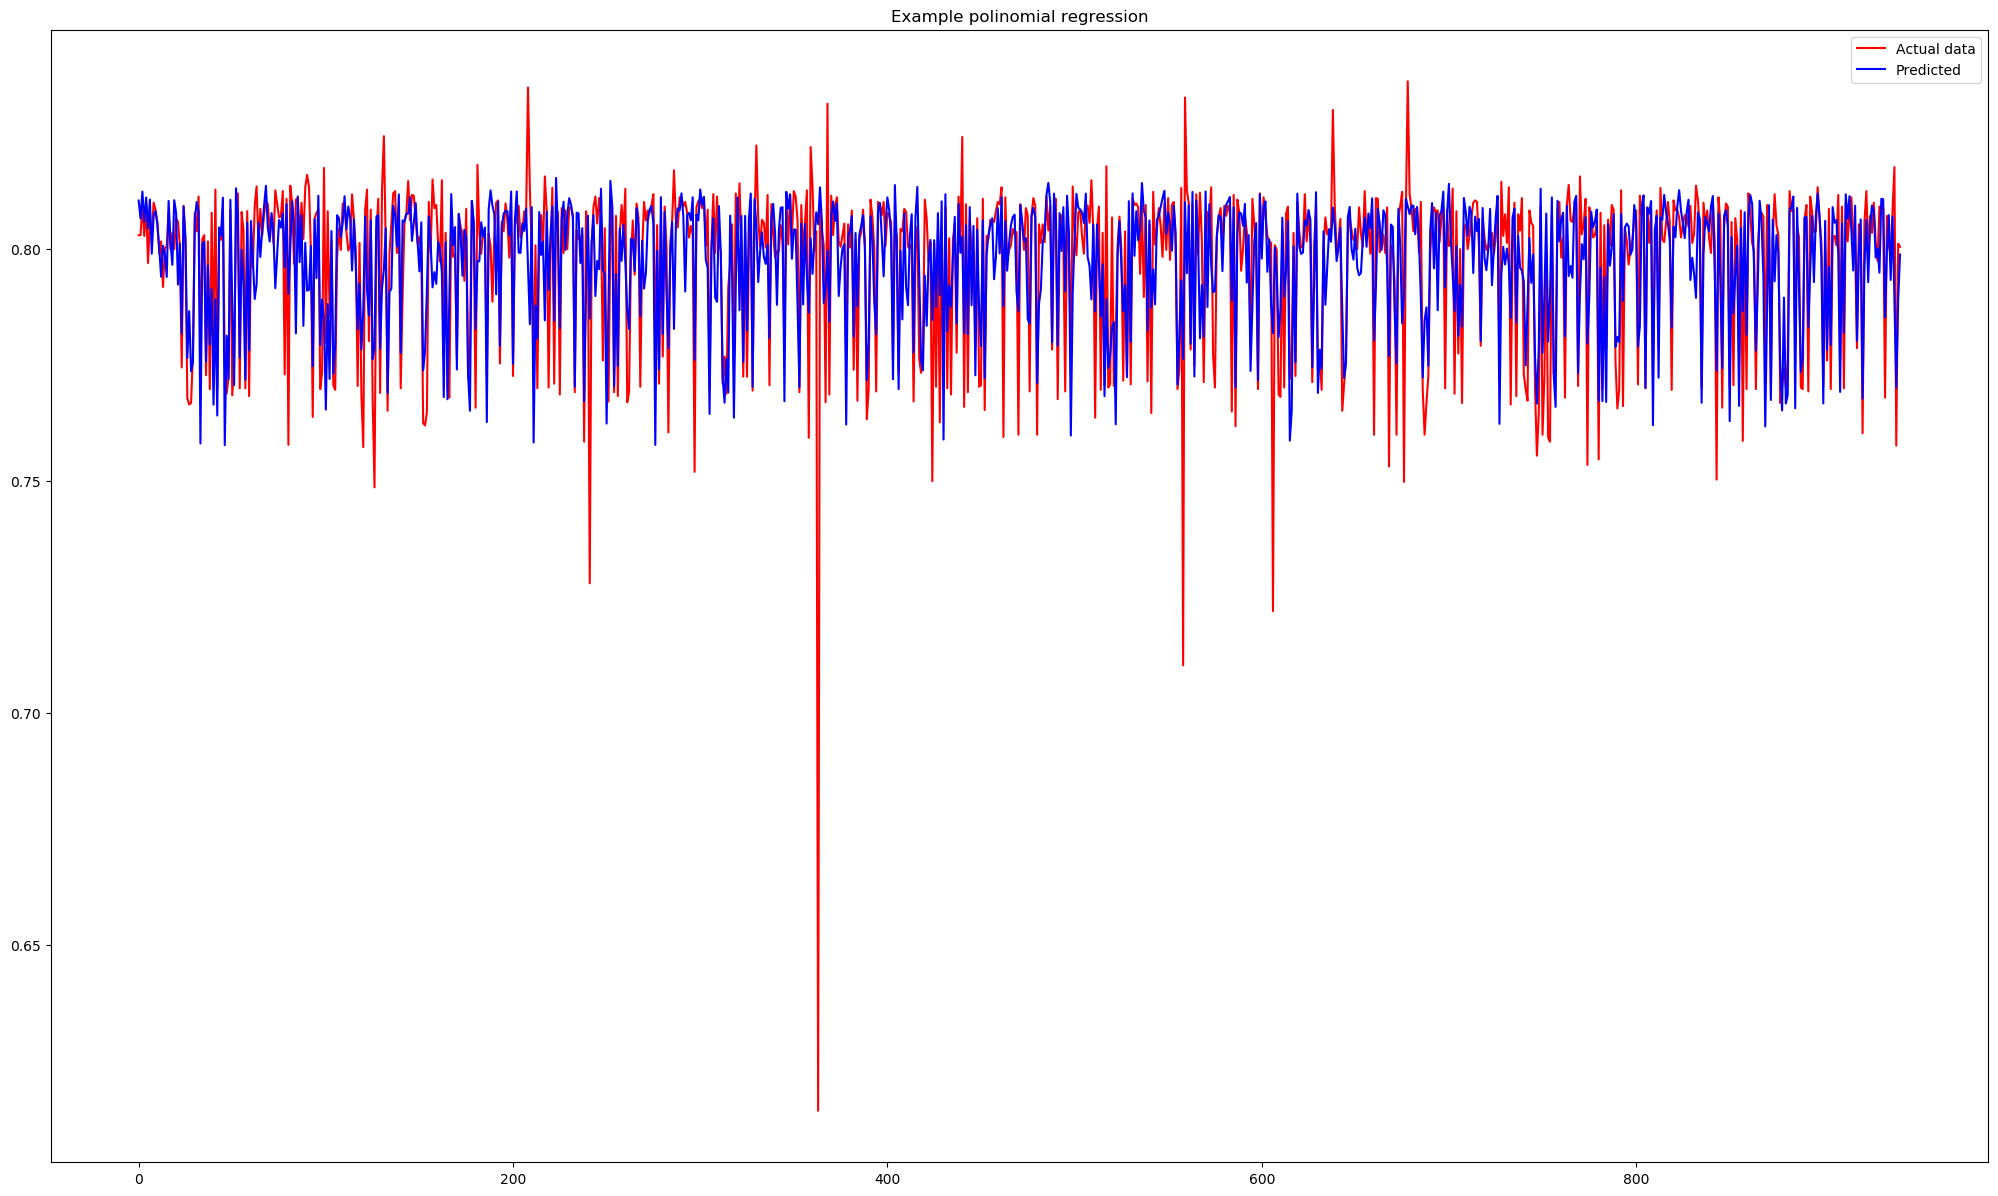

In [46]:
x_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_train)
x_test = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_test)

model = LinearRegression(fit_intercept=False).fit(x_, y_train)
y_pred = model.predict(x_test)

diff = mean_squared_error(y_test, y_pred)
print("MSE result:", diff, "\nMSE balanced by avg value: {:0.6f}".format((diff / mean(y_test))),"%")

plt.figure(figsize=(25, 15), dpi= 100)
plt.plot([i for i in range(len(y_test))], y_test, color='red', label="Actual data")
plt.plot([i for i in range(len(y_pred))], y_pred, color='blue', label="Predicted")
plt.title('Example polinomial regression')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.show()

In [9]:
"""
https://cppsecrets.com/users/5271114105115104979810446114107495548525364103109971051084699111109/Machine-Learning-Polynomial-Regression-in-Python.php

r_sq = model.score(x_, y_train)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
#generate a model of polynomial features
poly = PolynomialFeatures(degree=2)

#transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
X_ = poly.fit_transform(X)

#transform the prediction to fit the model type
predict_ = poly.fit_transform(predict)

#here we can remove polynomial orders we don't want
#for instance I'm removing the `x` component
X_ = np.delete(X_,(1),axis=1)
predict_ = np.delete(predict_,(1),axis=1)

#generate the regression object
clf = linear_model.LinearRegression()
#preform the actual regression
clf.fit(X_, vector)""";